In [9]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from buffer import MultiModelActivationBuffer

from datasets import load_dataset
import torch as t

from nnsight import LanguageModel
from buffer import MultiModelActivationBuffer
from trainers.top_k import TopKTrainer, AutoEncoderTopK
from dictionary import AutoEncoder
from training import trainSAE
from einops import rearrange, einsum
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda:0"
dtype = t.bfloat16
t.set_grad_enabled(False)

from dashboards import display_top_contexts_for_feature

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
layer = 7
# expansion = 2*8
num_tokens = int(50e6)
out_batch_size = 4096
model_name_list = ["Qwen/Qwen2.5-0.5B", "Qwen/Qwen2.5-0.5B-Instruct"]

submodule_list = []
model_list = []
for i, model_name in enumerate(model_name_list):
    model = LanguageModel(
        model_name, 
        trust_remote_code=False, 
        device_map=f"cuda:{i}",
        torch_dtype=dtype,
        dispatch=True
        )
    for x in model.parameters():
        x.requires_grad = False
    model_list.append(model)
    submodule_list.append(model.model.layers[layer])
    
activation_dim = 896
# dictionary_size = expansion * activation_dim

dataset = load_dataset(
    'Skylion007/openwebtext', 
    split='train', 
    streaming=True,
    trust_remote_code=True
    )

dataset = dataset.shuffle()

class CustomData():
    def __init__(self, dataset):
        self.data = iter(dataset)

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.data)['text']

data = CustomData(dataset)

buffer = MultiModelActivationBuffer(
    data=data,
    model_list=model_list,
    submodule_list=submodule_list,
    d_submodule=activation_dim, # output dimension of the model component
    n_ctxs=256,  # you can set this higher or lower dependong on your available memory
    device="cuda:2",
    refresh_batch_size=64,
    out_batch_size=out_batch_size,
    remove_bos=True,
    ctx_len=512
)  # buffer will yield batches of tensors of dimension = submodule's output dimension

In [13]:
ae = AutoEncoder.from_hf("jacobcd52/insecure_diffing", device="cuda:2")

/root/pretraining_diffing/notebooks/../dictionary.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(path)


Normalizing decoder weights


In [14]:
t.cuda.empty_cache()
import gc 
gc.collect()

20582

In [15]:
dec = rearrange(ae.decoder.weight, "(pair d) nf -> pair d nf", pair=2)
dec.shape

torch.Size([2, 896, 57344])

In [16]:
ae.decoder.weight.shape

torch.Size([1792, 57344])

In [28]:
norms = dec.pow(2).sum(dim=1).detach().cpu().float()
norms.shape

torch.Size([2, 57344])

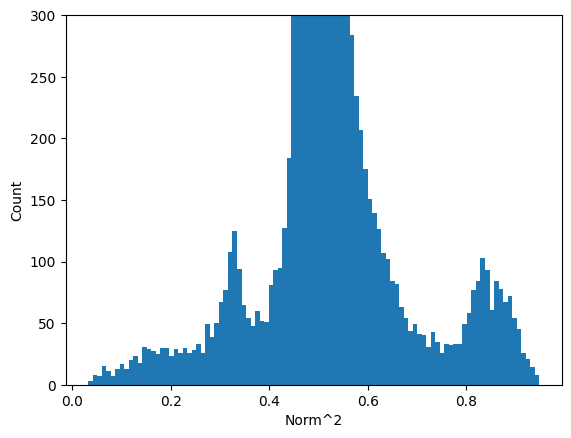

In [42]:
plt.hist(norms[0], bins=100)
# log scale
# axis titles
plt.xlabel('Norm^2')
plt.ylabel('Count')
# set yaxis range
plt.ylim(0,300)
plt.show()

In [33]:
0.04 * 64 * 896

2293.76

In [34]:
t.where(norms < 0.2)

(tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([ 2620,  2939,  3201,  ..., 57111, 57264, 57266]))